In [ ]:
!pip install git+https://github.com/Techtonique/nnetsauce.git@quantile --upgrade --no-cache-dir

In [ ]:
!pip install tabpfn

In [4]:
import nnetsauce as ns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabpfn import TabPFNRegressor
from sklearn.linear_model import RidgeCV
from time import time

In [5]:
import os
import nnetsauce as ns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import datasets, metrics
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.base.datetools import dates_from_str
from matplotlib import pyplot as plt

-------------------------------- realgovt
     year  quarter  realgdp  realcons  realinv  realgovt  realdpi   cpi  \
0 1959.00     1.00  2710.35   1707.40   286.90    470.05  1886.90 28.98   
1 1959.00     2.00  2778.80   1733.70   310.86    481.30  1919.70 29.15   
2 1959.00     3.00  2775.49   1751.80   289.23    491.26  1916.40 29.35   
3 1959.00     4.00  2785.20   1753.70   299.36    484.05  1931.30 29.37   
4 1960.00     1.00  2847.70   1770.50   331.72    462.20  1955.50 29.54   

      m1  tbilrate  unemp    pop  infl  realint  
0 139.70      2.82   5.80 177.15  0.00     0.00  
1 141.70      3.08   5.10 177.83  2.34     0.74  
2 140.50      3.82   5.30 178.66  2.74     1.09  
3 140.00      4.33   5.60 179.39  0.27     4.06  
4 139.60      3.50   5.20 180.01  2.31     1.19  

 Adjusting RidgeCV to multivariate time series... 



100%|██████████| 3/3 [00:00<00:00, 19.75it/s]



 Simulate residuals using gaussian kernel... 


 Best parameters for gaussian kernel: {'bandwidth': 0.75717214883374} 



100%|██████████| 250/250 [00:00<00:00, 2867.89it/s]


Time taken:  1.4809317588806152


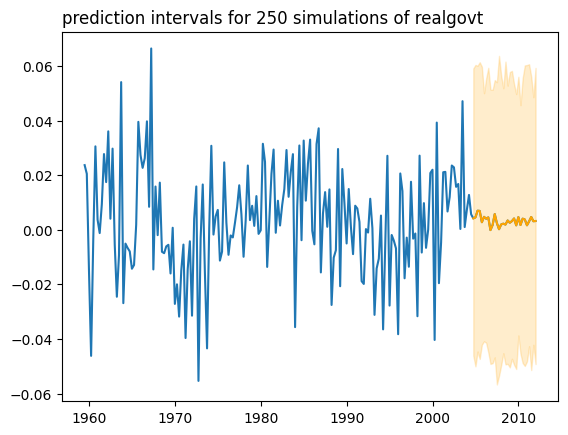

In [5]:
# Example

print("--------------------------------", "realgovt")

# some example data
mdata = sm.datasets.macrodata.load_pandas().data
# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
print(mdata.head())
mdata = mdata[['realgovt', 'tbilrate', 'cpi']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()
h = 30

n = data.shape[0]
max_idx_train = int(np.floor(n*0.9))
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n)
df_train = data.iloc[training_index,:]
#print(df_train.shape)
df_test = data.iloc[testing_index,:]

# Create trend and seasonal features for the full dataset first
n_total = len(data)
trend = np.arange(n_total)
seasonal = pd.get_dummies(data.index.quarter)  # quarterly seasonality

# Split data into train/test
max_idx_train = int(np.floor(n_total*0.9))
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n_total)

df_train = data.iloc[training_index]
df_test = data.iloc[testing_index]

# Split external regressors (trend and seasonality)
xreg_train = pd.DataFrame(
    np.column_stack([trend[training_index], seasonal.iloc[training_index]]),
    columns=['trend', 'Q1', 'Q2', 'Q3', 'Q4'],
    index=df_train.index  # Important: use same index as training data
)

xreg_test = pd.DataFrame(
    np.column_stack([trend[testing_index], seasonal.iloc[testing_index]]),
    columns=['trend', 'Q1', 'Q2', 'Q3', 'Q4'],
    index=df_test.index  # Important: use same index as test data
)

# Fit model
model = ns.MTS(RidgeCV(alphas=10**np.linspace(-3, 3, 100)),
               replications=250,
               lags=25,
               type_pi="scp2-kde",
               kernel='gaussian',
               verbose=1)
start = time()
model.fit(df_train, xreg=xreg_train)
predictions = model.predict(h=h)
print("Time taken: ", time()-start)
model.plot("realgovt", type_plot="pi")


 Adjusting TabPFNRegressor to multivariate time series... 



  0%|          | 0/3 [00:00<?, ?it/s]

tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

100%|██████████| 3/3 [06:59<00:00, 139.72s/it]



 Simulate residuals using gaussian kernel... 


 Best parameters for gaussian kernel: {'bandwidth': 0.75717214883374} 



100%|██████████| 250/250 [00:00<00:00, 2692.72it/s]


Time taken:  6548.131665229797


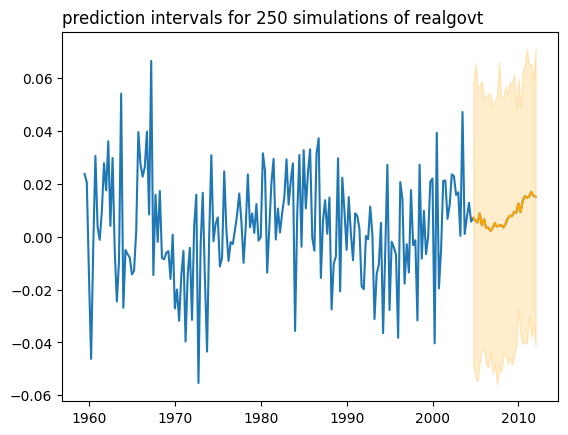

In [6]:
# Fit model
model = ns.MTS(TabPFNRegressor(),
               replications=250,
               lags=25,
               type_pi="scp2-kde",
               kernel='gaussian',
               verbose=1)
start = time()
model.fit(df_train, xreg=xreg_train)
predictions = model.predict(h=h)
print("Time taken: ", time()-start)
model.plot("realgovt", type_plot="pi")


 Adjusting RidgeCV to multivariate time series... 



100%|██████████| 2/2 [00:00<00:00, 13.83it/s]


 Simulate residuals using gaussian kernel... 




 Best parameters for gaussian kernel: {'bandwidth': 0.6290102436234454} 



100%|██████████| 250/250 [00:00<00:00, 2294.57it/s]


Time taken:  1.455399513244629


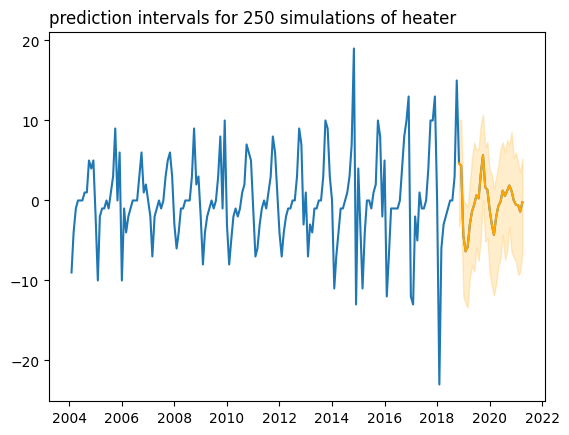

In [7]:
url = "https://raw.githubusercontent.com/Techtonique/datasets/main/time_series/multivariate/ice_cream_vs_heater.csv"
df_temp = pd.read_csv(url)
df_temp.index = pd.DatetimeIndex(df_temp.date)
data = df_temp.drop(columns=['date']).diff().dropna()
h = 30

n = data.shape[0]
max_idx_train = int(np.floor(n*0.9))
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n)
df_train = data.iloc[training_index,:]
df_test = data.iloc[testing_index,:]

# Create trend and seasonal features for the full dataset first
n_total = len(data)
trend = np.arange(n_total)
seasonal = pd.get_dummies(data.index.quarter)  # quarterly seasonality

# Split data into train/test
max_idx_train = int(np.floor(n_total*0.9))
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n_total)
df_train = data.iloc[training_index]
df_test = data.iloc[testing_index]

xreg_train = pd.DataFrame(
    np.column_stack([trend[training_index], seasonal.iloc[training_index]]),
    columns=['trend', 'Q1', 'Q2', 'Q3', 'Q4'],
    index=df_train.index  # Important: use same index as training data
)

xreg_test = pd.DataFrame(
    np.column_stack([trend[testing_index], seasonal.iloc[testing_index]]),
    columns=['trend', 'Q1', 'Q2', 'Q3', 'Q4'],
    index=df_test.index  # Important: use same index as test data
)

# Fit model
model = ns.MTS(RidgeCV(alphas=10**np.linspace(-10, 10, 100)),
               replications=250,
               lags=25,
               type_pi="scp2-kde",
               kernel='gaussian',
               verbose=1)
start = time()
model.fit(df_train, xreg=xreg_train)
predictions = model.predict(h=h)
print("Time taken: ", time()-start)
model.plot("heater", type_plot="pi")


 Adjusting TabPFNRegressor to multivariate time series... 



  0%|          | 0/2 [00:00<?, ?it/s]

tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

100%|██████████| 2/2 [04:10<00:00, 125.15s/it]



 Simulate residuals using gaussian kernel... 


 Best parameters for gaussian kernel: {'bandwidth': 0.5225415213602947} 



100%|██████████| 250/250 [00:00<00:00, 1717.06it/s]


Time taken:  3979.7243502140045


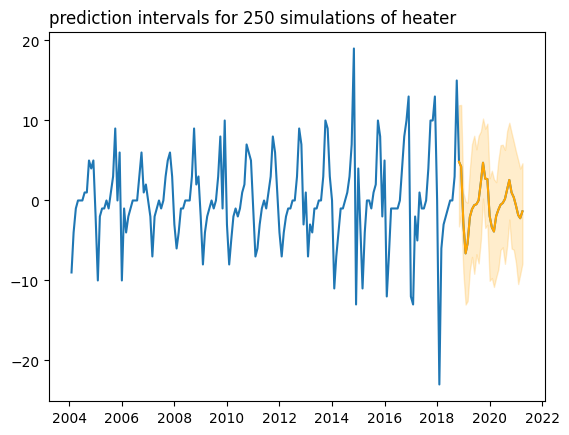

In [8]:
# Fit model
model = ns.MTS(TabPFNRegressor(),
               replications=250,
               lags=25,
               type_pi="scp2-kde",
               kernel='gaussian',
               verbose=1)
start = time()
model.fit(df_train, xreg=xreg_train)
predictions = model.predict(h=h)
print("Time taken: ", time()-start)
model.plot("heater", type_plot="pi")